# (1) Import

In [39]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

# (2) parameters


In [40]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [41]:
device = 'cuda'

# (3) data loading

In [42]:
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)

mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(),
                        target_transform=None, download=True)

In [43]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


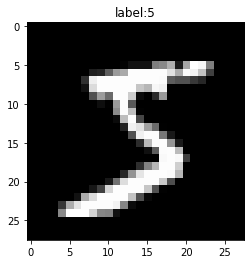

In [44]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

image, label = mnist_train.__getitem__(0)
print("image data 형태:", image.size())
print("label:", label)

img = image.numpy()
plt.title(f"label:{label}")
plt.imshow(img[0], cmap='gray')
plt.show()

# (4) Model

In [45]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # input tensor: (batch_size, seq_length, input_size)
    # x: (100, 28, 28)
    
    # hidden state tensor: (num_layers, batch_size, hidden_size)
    # h: (2, 100, 128)
    h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)

    # Forward propagets LSTM
    # output tensor: (batch_size, seq_length, hidden_size)
    # out: (100, 28, 28)
    
    out, _ = self.lstm(x, (h0, c0))

    # 28th output layer : (batch_size, hidden_size)
    # out[:, -1, :]: (100, 128)

    out = self.fc(out[:, -1, :])
    # y^: (batch_size, num_classes)
    # y_pred: (100, 10)

    return out

In [50]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [53]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader):
    # x; (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
    img = imgs
    img = img.reshape(-1, sequence_length, input_size).to(device)

    # y: (batch_size, num_classes)
    labels = labels.to(device)
    
    output = imodel(img)
    _, output_index = torch.max(output, 1)

    total += labels.size(0)
    correct += (output_index == labels).sum().float()

  return (100*correct/total)

In [54]:
print(f"Accuracy of Test Data: {ComputeAccr(test_loader, model)}")

Accuracy of Test Data: 10.09000015258789


# (5) loss function, optimizer

In [55]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# (6) train

In [58]:
total_step = len(train_loader)
for epochs in range(num_epochs):
  for i, [imgs, labels] in enumerate(train_loader):
    img = imgs
    img = img.reshape(-1, sequence_length, input_size).to(device)

    labels = labels.to(device)

    outputs = model(img)
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f"Epoch [{epochs+1}/{num_epochs}], Step [{i+1}/{total_step}], loss: {loss.item()}, Accr: {ComputeAccr(test_loader, model)}")

Epoch [1/2], Step [100/600], loss: 0.05954687297344208, Accr: 97.18999481201172
Epoch [1/2], Step [200/600], loss: 0.153119757771492, Accr: 96.97999572753906
Epoch [1/2], Step [300/600], loss: 0.05378260463476181, Accr: 97.29999542236328
Epoch [1/2], Step [400/600], loss: 0.06527180969715118, Accr: 97.52999877929688
Epoch [1/2], Step [500/600], loss: 0.20690388977527618, Accr: 97.45999908447266
Epoch [1/2], Step [600/600], loss: 0.14974823594093323, Accr: 97.73999786376953
Epoch [2/2], Step [100/600], loss: 0.09696631133556366, Accr: 97.58999633789062
Epoch [2/2], Step [200/600], loss: 0.011612411588430405, Accr: 97.93000030517578
Epoch [2/2], Step [300/600], loss: 0.024327421560883522, Accr: 97.89999389648438
Epoch [2/2], Step [400/600], loss: 0.06923641264438629, Accr: 97.98999786376953
Epoch [2/2], Step [500/600], loss: 0.08636899292469025, Accr: 97.5199966430664
Epoch [2/2], Step [600/600], loss: 0.17245979607105255, Accr: 97.87999725341797
